# Neural Networks - A Practical Introduction
by _Minho Menezes_  

---

## Neural Networks - Learning

In this second notebook, we build the intelligent algorithms that will learn the optimal set of weights for the Neural Network task. This is the Supervisioned Learning approach, and it is fundamental in Machine Learning.

* [1. Evaluating Performance](#1.-Evaluating-Performance)  
* [2. Backpropagation](#2.-Backpropagation)  
* [3. Gradient Descent Training](#3.-Gradient-Descent-Training)  
* [4. Training a MLP for Binary Classification](#4.-Training-a-MLP-for-Binary-Classification)  
* [5. Training a MLP for Multiclass Classification](#5.-Training-a-MLP-for-Multiclass-Classification)  

---

### Libraries

In [1]:
## LIBRARIES ##
import numpy as np                         # Library for Numerical and Matricial Operations
import matplotlib.pyplot as plt            # Library for Generating Visualizations
import pandas as pd                        # Library for Handling Datasets
from tools import Tools as tl              # Library for some Utilitary Tools

### Neural Network Class

In [2]:
## CLASS: Multilayer Perceptron ##
class MultilayerPerceptron:
    
    # CLASS CONSTRUCTOR
    def __init__(self, n_neurons=[2, 5, 1]):
        if(len(n_neurons) < 2):
            raise ValueError("The network must have at least two layers! (The input and the output layers)")
        
        # Network Architecture
        self.hidden_layers = len(n_neurons)-2
        self.n_neurons = n_neurons
        self.W = []
        
        # Adjusting the Network architecture
        for i in range(1, len(n_neurons)):
            self.W.append( np.random.randn(self.n_neurons[i-1]+1 , self.n_neurons[i]) )
        
    # ACTIVATION FUNCTION
    def activate(self,Z):
        return 1 / (1 + np.exp(-Z))
    
    # FORWARD PROPAGATION
    def forward(self, X):
        # Activation List
        A = []
        
        # Input Layer Activation
        A.append( np.vstack([np.ones([1, X.shape[1]]), X]) )
        
        # Hidden Layer Activation
        for i in range(0, self.hidden_layers):
            Z = np.matmul(self.W[i].T, A[-1])
            Z = self.activate(Z)
            
            A.append( np.vstack([np.ones([1, Z.shape[1]]), Z]) )
        
        # Output Layer Activation
        Z = np.matmul(self.W[-1].T, A[-1])
        Z = self.activate(Z)

        A.append(Z)
        
        return A
    
    # CLASSIFICATION PREDICTION
    def predict(self, X):
        A = self.forward(X)

        # Case: Multiclass
        if(self.n_neurons[-1] > 1):
            return A[-1].argmax(axis=0)

        # Case: Singleclass
        else:
            return (A[-1] > 0.5).astype(int)
    
    # LOSS FUNCTION
    def loss(self, y, y_hat):
        pass
    
    # ACCURACY FUNCTION
    def accuracy(self, y, y_hat):
        pass
    
    # BACKPROPAGATION
    def backpropagate(self, A, y):
        pass
    
    # GRADIENT DESCENT TRAINING
    def train(self, X_train, y_train, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=False):
        pass
        
## ---------------------------- ##

---
### 1. Evaluating Performance

One of the first things to be defined in any Supervisioned Learning approach is the evaluation and error metrics used to tell the model how it performed, and allow it to correct his parameters.

An important metric is the **Loss Function**, that direcly be used in the training. In our case, we will use the function known as _Cross-Entropy Loss_:

$$
    \mathcal{L}(W) = -\frac{1}{m} \sum y\ log( \hat{y} ) + (1-y)\ log(1 - \hat{y} )
$$

While it is mathematically useful for the training, its values are hard to interpret. So, a more human-like performance metric consists in the **Accuracy Function**, that can be calculated as:

$$
    \text{Acc}(W) = -\frac{100}{m} \sum ( y = \hat{y} )
$$

Implement the two evaluation metrics below:

In [3]:
# LOSS FUNCTION
def loss(self, y, y_hat):
    m = y.shape[1]
    return -(1/m) * np.sum(y * np.log(y_hat) + (1-y) * np.log(1 - y_hat))

# ACCURACY FUNCTION
def accuracy(self, y, y_hat):
    m = y.shape[1]
    return (1/m) * np.sum(y == y_hat) * 100

# Updates the methods directly in the MLP class
MultilayerPerceptron.loss = loss
MultilayerPerceptron.accuracy = accuracy

Now, use these metrics to evaluate the performance of classifiction for the examples in the matrix $X$:

In [4]:
# Creates a artificial toy dataset (Rows -> Attributes; Columns --> Samples)
X = np.array([[ 5,  1, -2, -1],
              [ 4,  2,  0,  4],
              [ 3,  3,  1,  4],
              [ 2,  4, -1, -3]])    

y = np.array([[ 1,  1,  0,  0]])

# Creates the Neural Network with 4 Input Neurons, 5 Hidden Neurons and 1 Output Neuron
# (The weights are randomnly initiated)
brain = MultilayerPerceptron(n_neurons=[4, 5, 1])

A = brain.forward(X) # Activation (Probability)
P = brain.predict(X) # Prediction (Class Index)

print("## RESULTS ##")
print("Real:       {}".format(y))
print("Predicted:  {}".format(P))
print("Activation: {}".format(A[-1]))

print()
print("Cross-Entropy Loss:  {}".format(brain.loss(y, A[-1])))
print("Prediction Accuracy: {}%".format(brain.accuracy(y, P)))

## RESULTS ##
Real:       [[1 1 0 0]]
Predicted:  [[0 0 0 0]]
Activation: [[0.10608102 0.27377442 0.31464858 0.17368901]]

Cross-Entropy Loss:  1.026902634736987
Prediction Accuracy: 50.0%


### 2. Backpropagation

The **Backpropagation** algorithm is one of the most popular and powerful techniques in traning multilayer models.

This algorithm allows the misclassification error to be distributed to the entire network, responsabilizing each neuron individually for its contribution to the faults. The algorithm work as follows.

The error in the output layer is directly the difference between the real value of the class for each sample subtracted by the probabilities calculated by the network. For all the subsequent layers, the error in each neuron is equal to:

$$
    e_i^{(l)} = \left( e_1^{(l+1)} W_1^{(l)} + e_2^{(l+1)} W_2^{(l)} + \cdots + e_n^{(l+1)} W_n^{(l)} \right) \cfrac{d \varphi(S_{i_\text{net}}^{(l)})}{dW}
$$

Where the derivative is equal to:

$$
    \cfrac{d \varphi(S_{i_\text{net}}^{(l)})}{dW} = A_i^{(l)}(1-A_i^{(l)})
$$

Using matrix multiplication, the backpropagation of the error between two layers is:

$$
    \mathbf{E}^{(l)} = \mathbf{W}^{(l)} \mathbf{E}^{(l+1)} \mathbf{A}^{(l)} (1 - \mathbf{A}^{(l)})
$$

Implement the backpropagation method in the cell below:

In [5]:
# BACKPROPAGATION
def backpropagate(self, A, y):
    # Calculates the error in the Output Layer (difference between the real and the predicted)
    E = []
    E.append( A[-1] - y )

    # Backpropagates the error to all the Hidden Layers
    for i in range(self.hidden_layers, 0, -1):
        E.append( np.matmul(self.W[i], E[-1]) * A[i] * (1-A[i]) )
        E[-1] = E[-1][1:,:]
        
    # Returns the list of Error Matrices
    return E[::-1]

# Updates the methods directly in the MLP class
MultilayerPerceptron.backpropagate = backpropagate

Now, experiment the _backpropagation()_ method in the example below:

In [6]:
# Creates a artificial toy dataset (Rows -> Attributes; Columns --> Samples)
X = np.array([[ 5,  1, -2, -1],
              [ 4,  2,  0,  4],
              [ 3,  3,  1,  4],
              [ 2,  4, -1, -3]])    

y = np.array([[ 1,  1,  0,  0]])

# Creates the Neural Network with 4 Input Neurons, 5 Hidden Neurons and 1 Output Neuron
# (The weights are randomnly initiated)
brain = MultilayerPerceptron(n_neurons=[4, 5, 1])

A = brain.forward(X)           # Activation
E = brain.backpropagate(A, y)  # Errors

# Show the results
print("## RESULTS ##")
print("Real:       {}".format(y))
print("Activation: {}".format(A[-1]))

print()
print("Error in Output Layer:\n", E[1])
print("\nError in Hidden Layer (Backpropagated):\n", E[0])


## RESULTS ##
Real:       [[1 1 0 0]]
Activation: [[0.93567557 0.94520244 0.8693045  0.79767477]]

Error in Output Layer:
 [[-0.06432443 -0.05479756  0.8693045   0.79767477]]

Error in Hidden Layer (Backpropagated):
 [[ 1.23606604e-04  5.41458912e-05 -3.72958947e-02 -2.50401231e-03]
 [-1.83559903e-02 -2.63747920e-04  2.49730218e-01  9.80805541e-02]
 [-6.43349561e-04 -1.29062779e-03  3.15731616e-02  6.81315213e-06]
 [-6.91364117e-04 -1.29145022e-03  5.89025750e-02  1.04673683e-02]
 [-1.67313455e-02 -1.95198332e-03  4.20083209e-02  2.00812901e-04]]


### 3. Gradient Descent Training

The **Gradient Descent** is the most popular iterative algorithm to optimize loss functions.

The algorithm works as follows:

Given a Multilayer Neural Network with $L$ layers, where $A^{(l)}$ is the activation matrix in each layer $l$, and $E^{(l)}$ is the error matrix for each layer $l$:

1. Calculate the activation $\mathbf{A}^{(l)}$ and the errors $\mathbf{E}^{(l)}$ using $\mathbf{W}^{(i)}$;  

2. Evaluate the current performance using the _Loss Function_ and the _Accuracy Metric_;
   
3. Update the network weights:

    $$ 
        \mathbf{W}^{(i+1)} = \mathbf{W}^{(i+1)} - \alpha \nabla \mathcal{L}(\mathbf{W}^{(i)})
    $$
    
    where $\alpha$ is a scaling factor (mostly between 0 and 1) called _Learning Rate_, and $\nabla \mathcal{L}(\mathbf{W}^{(i)})$ represents the gradient of the _cost function_, that can be calculated as:
    
    $$ 
        \nabla \mathcal{L}(\mathbf{W}^{(i)}) = (A^{(l)}) E^{(l)^T}
    $$  <br>
    
4. Print the training results at each 50 epochs  <br>

5. Check for convergence by comparing the decrease in the _Loss Function_; <br>

6. If the training did not converged, go back to Step 1. <br>

In [7]:
# GRADIENT DESCENT TRAINING
def train(self, X_train, y_train, alpha=1e-3, maxIt=50000, tol=1e-5, verbose=True):
    # Returns the total number of samples in the training
    m = X_train.shape[1]
    
    # Defines the Error History and other auxiliary variables
    errorHist = []
    
    # Gradient Descent Loop
    for it in range(0, maxIt):
        # 1. Calculates all the activations and prediction (Forward Propagation) and 
        #    the errors (Backpropagation), using the current weights self.Wˆ(i)
        A = self.forward(X_train)
        E = self.backpropagate(A, y_train)
        P = self.predict(X_train)
        
        # 2. Calculates the Evaluation Metrics
        actualLoss = self.loss(y_train, A[-1])
        actualAcc = self.accuracy(y_train, P)
        errorHist.append(actualLoss)
        
        # 3. Updates the Neural Networks weights
        for i in range(0, self.hidden_layers+1):
            self.W[i] = self.W[i] - (alpha/m) * np.matmul(A[i], E[i].T)
        
        # 4. Prints the training results
        if(verbose): 
            print("# Iteration {0:5} -> Loss: {1:} \t| Accuracy: {2:.3f}".format(it+1, actualLoss, actualAcc))
        
        # 5. Check for convergence and prints the final result for the training.
        if(it > 1 and abs(errorHist[-1] - errorHist[-2]) <= tol):
            print("\n!!! Convergence reached !!!")
            print("# Iteration", it, "#")
            print("Cross-Entropy Loss:      {}".format(actualLoss))
            print("Accuracy (Training Set): {0:.3f}%".format(actualAcc))
            print("Weights\nS -> H:\n", self.W[0], "\nH -> O:\n", self.W[1])
            print("\n")
            break;
        
    # End of the Training
    return errorHist

# Updates the methods directly in the MLP class
MultilayerPerceptron.train = train

### 4. Training a MLP for Binary Classification

The training process updates the weights to a optimum set of values, that minimizes the classification error, i.e., the Loss Function. Once that our algorithm for training is successfully implemented, we can use our Neural Network to train over a specific training set of data in order to learn the pattern of classification in that data.

Consider our already known Multilayer Perceptron for binary classification:

<img src="../imgs/mlp_01.png" alt="binary multilayer perceptron" width="350px"/>

**We will train this network using the dataset from the previous notebook:**

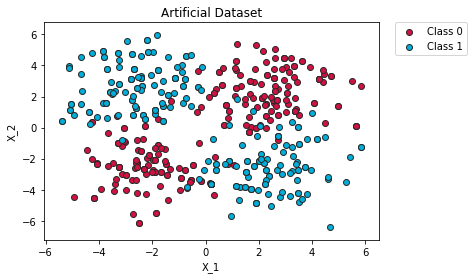

In [8]:
# Loads and plot the data from the artificial dataset
X_train, X_test, y_train, y_test = tl.loadData("../data/toy_data_01.csv")
tl.plotData(X_train, y_train)

After we create the Neural Network with the wanted architecture, all we need to do is run the _train()_ method passing the desired training data:

In [9]:
# Creates the Neural Network with 2 Input Neurons, 10 Hidden Neurons and 1 Output Neuron
# (The weights are randomnly initiated)
brain = MultilayerPerceptron(n_neurons=[2,10,1])

# Run the Gradient Descent and returns the Error History for the training.
errorHist = brain.train(X_train, y_train, alpha=0.1)

# Iteration     1 -> Loss: 1.1069656913486885 	| Accuracy: 51.875
# Iteration     2 -> Loss: 1.0602507470415503 	| Accuracy: 51.875
# Iteration     3 -> Loss: 1.0171770814496108 	| Accuracy: 51.875
# Iteration     4 -> Loss: 0.9777485546637303 	| Accuracy: 51.875
# Iteration     5 -> Loss: 0.9419212225881606 	| Accuracy: 51.875
# Iteration     6 -> Loss: 0.9096035816464069 	| Accuracy: 51.875
# Iteration     7 -> Loss: 0.8806596524394888 	| Accuracy: 51.875
# Iteration     8 -> Loss: 0.8549146318848074 	| Accuracy: 51.875
# Iteration     9 -> Loss: 0.8321625225149082 	| Accuracy: 51.875
# Iteration    10 -> Loss: 0.8121749392285347 	| Accuracy: 51.875
# Iteration    11 -> Loss: 0.7947102326670278 	| Accuracy: 51.875
# Iteration    12 -> Loss: 0.7795221486345958 	| Accuracy: 51.875
# Iteration    13 -> Loss: 0.7663674255583541 	| Accuracy: 51.875
# Iteration    14 -> Loss: 0.7550119621973284 	| Accuracy: 51.875
# Iteration    15 -> Loss: 0.745235413801606 	| Accuracy: 51.875
# Iteration

# Iteration   241 -> Loss: 0.5765171635689592 	| Accuracy: 81.250
# Iteration   242 -> Loss: 0.5759552173041376 	| Accuracy: 81.250
# Iteration   243 -> Loss: 0.5753924583230574 	| Accuracy: 81.250
# Iteration   244 -> Loss: 0.5748288846892178 	| Accuracy: 81.250
# Iteration   245 -> Loss: 0.5742644946398597 	| Accuracy: 81.458
# Iteration   246 -> Loss: 0.5736992865875754 	| Accuracy: 81.458
# Iteration   247 -> Loss: 0.573133259121919 	| Accuracy: 82.083
# Iteration   248 -> Loss: 0.5725664110110216 	| Accuracy: 82.083
# Iteration   249 -> Loss: 0.5719987412032084 	| Accuracy: 82.292
# Iteration   250 -> Loss: 0.571430248828621 	| Accuracy: 82.292
# Iteration   251 -> Loss: 0.5708609332008424 	| Accuracy: 82.292
# Iteration   252 -> Loss: 0.5702907938185261 	| Accuracy: 82.292
# Iteration   253 -> Loss: 0.5697198303670292 	| Accuracy: 82.292
# Iteration   254 -> Loss: 0.5691480427200493 	| Accuracy: 82.292
# Iteration   255 -> Loss: 0.5685754309412645 	| Accuracy: 82.292
# Iteration 

# Iteration   481 -> Loss: 0.43516371230185635 	| Accuracy: 90.208
# Iteration   482 -> Loss: 0.4346373112448407 	| Accuracy: 90.208
# Iteration   483 -> Loss: 0.43411182624647693 	| Accuracy: 90.208
# Iteration   484 -> Loss: 0.43358725807636594 	| Accuracy: 90.208
# Iteration   485 -> Loss: 0.4330636074869132 	| Accuracy: 90.208
# Iteration   486 -> Loss: 0.4325408752135208 	| Accuracy: 90.208
# Iteration   487 -> Loss: 0.4320190619747663 	| Accuracy: 90.208
# Iteration   488 -> Loss: 0.431498168472568 	| Accuracy: 90.208
# Iteration   489 -> Loss: 0.43097819539233917 	| Accuracy: 90.208
# Iteration   490 -> Loss: 0.43045914340312913 	| Accuracy: 90.208
# Iteration   491 -> Loss: 0.42994101315775524 	| Accuracy: 89.583
# Iteration   492 -> Loss: 0.42942380529292357 	| Accuracy: 89.583
# Iteration   493 -> Loss: 0.42890752042933994 	| Accuracy: 89.583
# Iteration   494 -> Loss: 0.42839215917181217 	| Accuracy: 89.583
# Iteration   495 -> Loss: 0.4278777221093441 	| Accuracy: 89.583
# 

# Iteration   726 -> Loss: 0.3332982532703134 	| Accuracy: 91.458
# Iteration   727 -> Loss: 0.33298549332029986 	| Accuracy: 91.458
# Iteration   728 -> Loss: 0.33267346001589715 	| Accuracy: 91.458
# Iteration   729 -> Loss: 0.33236215177765555 	| Accuracy: 91.458
# Iteration   730 -> Loss: 0.3320515670260896 	| Accuracy: 91.458
# Iteration   731 -> Loss: 0.3317417041817255 	| Accuracy: 91.458
# Iteration   732 -> Loss: 0.3314325616651488 	| Accuracy: 91.458
# Iteration   733 -> Loss: 0.3311241378970506 	| Accuracy: 91.458
# Iteration   734 -> Loss: 0.3308164312982735 	| Accuracy: 91.458
# Iteration   735 -> Loss: 0.3305094402898571 	| Accuracy: 91.458
# Iteration   736 -> Loss: 0.33020316329308247 	| Accuracy: 91.458
# Iteration   737 -> Loss: 0.32989759872951646 	| Accuracy: 91.458
# Iteration   738 -> Loss: 0.32959274502105496 	| Accuracy: 91.458
# Iteration   739 -> Loss: 0.3292886005899665 	| Accuracy: 91.458
# Iteration   740 -> Loss: 0.32898516385893356 	| Accuracy: 91.458
# I

# Iteration   986 -> Loss: 0.27214273725206356 	| Accuracy: 92.708
# Iteration   987 -> Loss: 0.2719705170609495 	| Accuracy: 92.708
# Iteration   988 -> Loss: 0.27179867751001163 	| Accuracy: 92.708
# Iteration   989 -> Loss: 0.27162721760564185 	| Accuracy: 92.708
# Iteration   990 -> Loss: 0.27145613635674537 	| Accuracy: 92.708
# Iteration   991 -> Loss: 0.2712854327747365 	| Accuracy: 92.708
# Iteration   992 -> Loss: 0.2711151058735337 	| Accuracy: 92.708
# Iteration   993 -> Loss: 0.27094515466955527 	| Accuracy: 92.708
# Iteration   994 -> Loss: 0.27077557818171427 	| Accuracy: 92.708
# Iteration   995 -> Loss: 0.27060637543141425 	| Accuracy: 92.708
# Iteration   996 -> Loss: 0.2704375454425443 	| Accuracy: 92.708
# Iteration   997 -> Loss: 0.2702690872414742 	| Accuracy: 92.708
# Iteration   998 -> Loss: 0.2701009998570502 	| Accuracy: 92.708
# Iteration   999 -> Loss: 0.26993328232059005 	| Accuracy: 92.708
# Iteration  1000 -> Loss: 0.26976593366587814 	| Accuracy: 92.708
#

# Iteration  1249 -> Loss: 0.23742760049449682 	| Accuracy: 93.125
# Iteration  1250 -> Loss: 0.2373278921919733 	| Accuracy: 93.125
# Iteration  1251 -> Loss: 0.23722837618178771 	| Accuracy: 93.125
# Iteration  1252 -> Loss: 0.23712905197842477 	| Accuracy: 93.125
# Iteration  1253 -> Loss: 0.23702991909776952 	| Accuracy: 93.125
# Iteration  1254 -> Loss: 0.23693097705710375 	| Accuracy: 93.125
# Iteration  1255 -> Loss: 0.23683222537510235 	| Accuracy: 93.125
# Iteration  1256 -> Loss: 0.23673366357182965 	| Accuracy: 93.125
# Iteration  1257 -> Loss: 0.23663529116873583 	| Accuracy: 93.125
# Iteration  1258 -> Loss: 0.23653710768865294 	| Accuracy: 93.125
# Iteration  1259 -> Loss: 0.23643911265579168 	| Accuracy: 93.125
# Iteration  1260 -> Loss: 0.2363413055957374 	| Accuracy: 93.125
# Iteration  1261 -> Loss: 0.23624368603544663 	| Accuracy: 93.125
# Iteration  1262 -> Loss: 0.23614625350324325 	| Accuracy: 93.125
# Iteration  1263 -> Loss: 0.23604900752881516 	| Accuracy: 93.1

# Iteration  1625 -> Loss: 0.21016904539517067 	| Accuracy: 93.750
# Iteration  1626 -> Loss: 0.21011702054258719 	| Accuracy: 93.750
# Iteration  1627 -> Loss: 0.21006507626905924 	| Accuracy: 93.750
# Iteration  1628 -> Loss: 0.21001321240625226 	| Accuracy: 93.750
# Iteration  1629 -> Loss: 0.20996142878626997 	| Accuracy: 93.750
# Iteration  1630 -> Loss: 0.20990972524165297 	| Accuracy: 93.750
# Iteration  1631 -> Loss: 0.2098581016053772 	| Accuracy: 93.750
# Iteration  1632 -> Loss: 0.20980655771085305 	| Accuracy: 93.750
# Iteration  1633 -> Loss: 0.20975509339192336 	| Accuracy: 93.750
# Iteration  1634 -> Loss: 0.20970370848286254 	| Accuracy: 93.750
# Iteration  1635 -> Loss: 0.20965240281837522 	| Accuracy: 93.750
# Iteration  1636 -> Loss: 0.20960117623359442 	| Accuracy: 93.750
# Iteration  1637 -> Loss: 0.20955002856408086 	| Accuracy: 93.750
# Iteration  1638 -> Loss: 0.20949895964582108 	| Accuracy: 93.750
# Iteration  1639 -> Loss: 0.2094479693152265 	| Accuracy: 93.7

# Iteration  1883 -> Loss: 0.19900994747682663 	| Accuracy: 93.958
# Iteration  1884 -> Loss: 0.1989741617387756 	| Accuracy: 93.958
# Iteration  1885 -> Loss: 0.1989384245289724 	| Accuracy: 93.958
# Iteration  1886 -> Loss: 0.19890273575769335 	| Accuracy: 93.958
# Iteration  1887 -> Loss: 0.19886709533541946 	| Accuracy: 93.958
# Iteration  1888 -> Loss: 0.19883150317283635 	| Accuracy: 93.958
# Iteration  1889 -> Loss: 0.19879595918083298 	| Accuracy: 93.958
# Iteration  1890 -> Loss: 0.19876046327050176 	| Accuracy: 93.958
# Iteration  1891 -> Loss: 0.19872501535313764 	| Accuracy: 93.958
# Iteration  1892 -> Loss: 0.19868961534023763 	| Accuracy: 93.958
# Iteration  1893 -> Loss: 0.19865426314350015 	| Accuracy: 93.958
# Iteration  1894 -> Loss: 0.19861895867482476 	| Accuracy: 93.958
# Iteration  1895 -> Loss: 0.19858370184631124 	| Accuracy: 93.958
# Iteration  1896 -> Loss: 0.1985484925702594 	| Accuracy: 93.958
# Iteration  1897 -> Loss: 0.1985133307591682 	| Accuracy: 93.958

# Iteration  2142 -> Loss: 0.1911389248333164 	| Accuracy: 95.000
# Iteration  2143 -> Loss: 0.19111320831559103 	| Accuracy: 95.000
# Iteration  2144 -> Loss: 0.1910875226047077 	| Accuracy: 95.000
# Iteration  2145 -> Loss: 0.19106186764942776 	| Accuracy: 95.000
# Iteration  2146 -> Loss: 0.19103624339861738 	| Accuracy: 95.000
# Iteration  2147 -> Loss: 0.19101064980124757 	| Accuracy: 95.000
# Iteration  2148 -> Loss: 0.19098508680639367 	| Accuracy: 95.000
# Iteration  2149 -> Loss: 0.19095955436323528 	| Accuracy: 95.000
# Iteration  2150 -> Loss: 0.19093405242105585 	| Accuracy: 95.000
# Iteration  2151 -> Loss: 0.19090858092924268 	| Accuracy: 95.000
# Iteration  2152 -> Loss: 0.19088313983728622 	| Accuracy: 95.000
# Iteration  2153 -> Loss: 0.1908577290947805 	| Accuracy: 95.000
# Iteration  2154 -> Loss: 0.19083234865142207 	| Accuracy: 95.000
# Iteration  2155 -> Loss: 0.19080699845701043 	| Accuracy: 95.000
# Iteration  2156 -> Loss: 0.19078167846144745 	| Accuracy: 95.00

# Iteration  2403 -> Loss: 0.18533971110418435 	| Accuracy: 95.000
# Iteration  2404 -> Loss: 0.18532056192718147 	| Accuracy: 95.000
# Iteration  2405 -> Loss: 0.18530143311249844 	| Accuracy: 95.000
# Iteration  2406 -> Loss: 0.18528232462935565 	| Accuracy: 95.000
# Iteration  2407 -> Loss: 0.1852632364470305 	| Accuracy: 95.000
# Iteration  2408 -> Loss: 0.18524416853485762 	| Accuracy: 95.000
# Iteration  2409 -> Loss: 0.18522512086222842 	| Accuracy: 95.000
# Iteration  2410 -> Loss: 0.18520609339859123 	| Accuracy: 95.000
# Iteration  2411 -> Loss: 0.18518708611345092 	| Accuracy: 95.000
# Iteration  2412 -> Loss: 0.18516809897636893 	| Accuracy: 95.000
# Iteration  2413 -> Loss: 0.18514913195696317 	| Accuracy: 95.000
# Iteration  2414 -> Loss: 0.18513018502490777 	| Accuracy: 95.000
# Iteration  2415 -> Loss: 0.1851112581499331 	| Accuracy: 95.000
# Iteration  2416 -> Loss: 0.18509235130182544 	| Accuracy: 95.000
# Iteration  2417 -> Loss: 0.18507346445042708 	| Accuracy: 95.0

# Iteration  2659 -> Loss: 0.18102606887507383 	| Accuracy: 95.000
# Iteration  2660 -> Loss: 0.1810112661180509 	| Accuracy: 95.000
# Iteration  2661 -> Loss: 0.1809964774078211 	| Accuracy: 95.000
# Iteration  2662 -> Loss: 0.18098170272484526 	| Accuracy: 95.000
# Iteration  2663 -> Loss: 0.1809669420496175 	| Accuracy: 95.000
# Iteration  2664 -> Loss: 0.1809521953626647 	| Accuracy: 95.000
# Iteration  2665 -> Loss: 0.18093746264454666 	| Accuracy: 95.000
# Iteration  2666 -> Loss: 0.18092274387585616 	| Accuracy: 95.000
# Iteration  2667 -> Loss: 0.18090803903721872 	| Accuracy: 95.000
# Iteration  2668 -> Loss: 0.18089334810929247 	| Accuracy: 95.000
# Iteration  2669 -> Loss: 0.18087867107276842 	| Accuracy: 95.000
# Iteration  2670 -> Loss: 0.18086400790836984 	| Accuracy: 95.000
# Iteration  2671 -> Loss: 0.18084935859685292 	| Accuracy: 95.000
# Iteration  2672 -> Loss: 0.18083472311900586 	| Accuracy: 95.000
# Iteration  2673 -> Loss: 0.18082010145564958 	| Accuracy: 95.000

# Iteration  2913 -> Loss: 0.17766984368007743 	| Accuracy: 95.000
# Iteration  2914 -> Loss: 0.1776580599134742 	| Accuracy: 95.000
# Iteration  2915 -> Loss: 0.17764628613313746 	| Accuracy: 95.000
# Iteration  2916 -> Loss: 0.17763452232610794 	| Accuracy: 95.000
# Iteration  2917 -> Loss: 0.17762276847944614 	| Accuracy: 95.000
# Iteration  2918 -> Loss: 0.17761102458023256 	| Accuracy: 95.000
# Iteration  2919 -> Loss: 0.17759929061556765 	| Accuracy: 95.000
# Iteration  2920 -> Loss: 0.1775875665725716 	| Accuracy: 95.000
# Iteration  2921 -> Loss: 0.1775758524383844 	| Accuracy: 95.000
# Iteration  2922 -> Loss: 0.17756414820016594 	| Accuracy: 95.000
# Iteration  2923 -> Loss: 0.1775524538450957 	| Accuracy: 95.000
# Iteration  2924 -> Loss: 0.17754076936037286 	| Accuracy: 95.000
# Iteration  2925 -> Loss: 0.17752909473321632 	| Accuracy: 95.000
# Iteration  2926 -> Loss: 0.17751742995086453 	| Accuracy: 95.000
# Iteration  2927 -> Loss: 0.17750577500057566 	| Accuracy: 95.000

We then can classify the entire training data space in order to see the pattern that our Neural Network learned _(I recommend you to change the Neural Network architecture and the training parameters in the previous cell in order to see different patterns that the Network can fit)_:

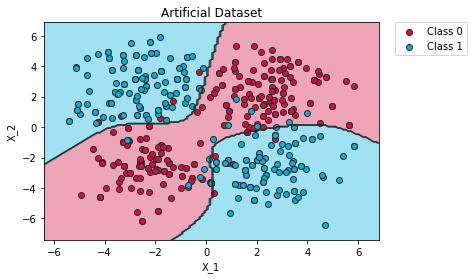

In [10]:
# Classify and plot the results for the entire dataset space using the trained Network
tl.plotClassContour(X_train, y_train, brain)

### 5. Training a MLP for Multiclass Classification

The training process in the casse of multiclass classification is exactly the same for the binary case. In this case, however, the outputs in the Training data must follow the [One-Hot Encoding](https://www.kaggle.com/dansbecker/using-categorical-data-with-one-hot-encoding) in order to be compared to the network's activation in the output layer (that is now a vector).

Consider our already known Multilayer Perceptron for multiclass classification:

<img src="../imgs/mlp_02.png" alt="binary multilayer perceptron" width="350px"/>

**We will train this network using the dataset from the previous notebook:**

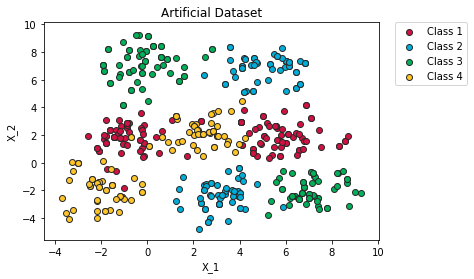

In [11]:
## CARREGANDO E VISUALIZANDO OS DADOS ##
X_train, X_test, y_train, y_test = tl.loadData("../data/toy_data_02.csv")
tl.plotData(X_train, y_train)

After we create the Neural Network with the wanted architecture, all we need to do is run the train() method passing the desired training data. Remember to set the number of output neurons to be equal to 4:

In [12]:
# Creates the Neural Network with 2 Input Neurons, 10 Hidden Neurons and 4 Output Neuron
# (The weights are randomnly initiated)
brain = MultilayerPerceptron(n_neurons=[2,10,4])

# Run the Gradient Descent and returns the Error History for the training.
errorHist = brain.train(X_train, y_train, alpha=0.1)

# Iteration     1 -> Loss: 3.3045442255951247 	| Accuracy: 42.917
# Iteration     2 -> Loss: 3.189861744291028 	| Accuracy: 43.125
# Iteration     3 -> Loss: 3.0858655280091476 	| Accuracy: 43.750
# Iteration     4 -> Loss: 2.9932522582527303 	| Accuracy: 60.833
# Iteration     5 -> Loss: 2.911819605983686 	| Accuracy: 81.667
# Iteration     6 -> Loss: 2.8403441026698184 	| Accuracy: 93.542
# Iteration     7 -> Loss: 2.7770438484149813 	| Accuracy: 99.375
# Iteration     8 -> Loss: 2.7201603513091057 	| Accuracy: 107.917
# Iteration     9 -> Loss: 2.668299676463272 	| Accuracy: 115.833
# Iteration    10 -> Loss: 2.620497332953709 	| Accuracy: 124.583
# Iteration    11 -> Loss: 2.5761258289112563 	| Accuracy: 129.792
# Iteration    12 -> Loss: 2.53475986472217 	| Accuracy: 136.458
# Iteration    13 -> Loss: 2.496071082338638 	| Accuracy: 146.458
# Iteration    14 -> Loss: 2.45977694972295 	| Accuracy: 148.333
# Iteration    15 -> Loss: 2.42562990861672 	| Accuracy: 150.417
# Iteration  

# Iteration   186 -> Loss: 1.5112013247819633 	| Accuracy: 130.625
# Iteration   187 -> Loss: 1.5098704152802898 	| Accuracy: 130.625
# Iteration   188 -> Loss: 1.5085433476051702 	| Accuracy: 130.625
# Iteration   189 -> Loss: 1.5072201032502148 	| Accuracy: 130.625
# Iteration   190 -> Loss: 1.5059006643501505 	| Accuracy: 130.625
# Iteration   191 -> Loss: 1.504585013629604 	| Accuracy: 130.625
# Iteration   192 -> Loss: 1.5032731343540024 	| Accuracy: 130.625
# Iteration   193 -> Loss: 1.5019650102825555 	| Accuracy: 130.625
# Iteration   194 -> Loss: 1.5006606256232806 	| Accuracy: 130.625
# Iteration   195 -> Loss: 1.4993599649900269 	| Accuracy: 130.625
# Iteration   196 -> Loss: 1.4980630133614683 	| Accuracy: 130.208
# Iteration   197 -> Loss: 1.4967697560420214 	| Accuracy: 130.208
# Iteration   198 -> Loss: 1.495480178624651 	| Accuracy: 130.208
# Iteration   199 -> Loss: 1.4941942669555275 	| Accuracy: 130.208
# Iteration   200 -> Loss: 1.4929120071004962 	| Accuracy: 130.2

# Iteration   342 -> Loss: 1.3403685823670077 	| Accuracy: 129.792
# Iteration   343 -> Loss: 1.3394486676546327 	| Accuracy: 129.792
# Iteration   344 -> Loss: 1.3385303368341945 	| Accuracy: 129.792
# Iteration   345 -> Loss: 1.3376135841113248 	| Accuracy: 129.792
# Iteration   346 -> Loss: 1.3366984038510468 	| Accuracy: 129.792
# Iteration   347 -> Loss: 1.3357847905741853 	| Accuracy: 129.792
# Iteration   348 -> Loss: 1.3348727389536739 	| Accuracy: 129.792
# Iteration   349 -> Loss: 1.3339622438107686 	| Accuracy: 129.792
# Iteration   350 -> Loss: 1.3330533001111704 	| Accuracy: 129.792
# Iteration   351 -> Loss: 1.3321459029610612 	| Accuracy: 129.792
# Iteration   352 -> Loss: 1.3312400476030664 	| Accuracy: 129.792
# Iteration   353 -> Loss: 1.3303357294121336 	| Accuracy: 129.792
# Iteration   354 -> Loss: 1.3294329438913546 	| Accuracy: 129.792
# Iteration   355 -> Loss: 1.328531686667716 	| Accuracy: 129.792
# Iteration   356 -> Loss: 1.3276319534878 	| Accuracy: 129.792

# Iteration   495 -> Loss: 1.215843111463621 	| Accuracy: 129.792
# Iteration   496 -> Loss: 1.2151212354569876 	| Accuracy: 129.792
# Iteration   497 -> Loss: 1.2144003310714448 	| Accuracy: 129.792
# Iteration   498 -> Loss: 1.213680394575576 	| Accuracy: 129.792
# Iteration   499 -> Loss: 1.212961422281885 	| Accuracy: 129.792
# Iteration   500 -> Loss: 1.2122434105472606 	| Accuracy: 129.792
# Iteration   501 -> Loss: 1.2115263557734255 	| Accuracy: 129.792
# Iteration   502 -> Loss: 1.210810254407365 	| Accuracy: 129.792
# Iteration   503 -> Loss: 1.210095102941744 	| Accuracy: 129.792
# Iteration   504 -> Loss: 1.2093808979153002 	| Accuracy: 129.792
# Iteration   505 -> Loss: 1.2086676359132293 	| Accuracy: 129.792
# Iteration   506 -> Loss: 1.2079553135675472 	| Accuracy: 129.792
# Iteration   507 -> Loss: 1.20724392755744 	| Accuracy: 129.792
# Iteration   508 -> Loss: 1.2065334746095975 	| Accuracy: 129.792
# Iteration   509 -> Loss: 1.2058239514985303 	| Accuracy: 129.792
# 

# Iteration   695 -> Loss: 1.0885789192046478 	| Accuracy: 132.292
# Iteration   696 -> Loss: 1.088024888503438 	| Accuracy: 132.292
# Iteration   697 -> Loss: 1.087471622973338 	| Accuracy: 132.292
# Iteration   698 -> Loss: 1.0869191208361155 	| Accuracy: 132.292
# Iteration   699 -> Loss: 1.0863673802965195 	| Accuracy: 132.292
# Iteration   700 -> Loss: 1.0858163995426735 	| Accuracy: 132.292
# Iteration   701 -> Loss: 1.0852661767464766 	| Accuracy: 132.292
# Iteration   702 -> Loss: 1.0847167100639967 	| Accuracy: 132.292
# Iteration   703 -> Loss: 1.08416799763587 	| Accuracy: 132.292
# Iteration   704 -> Loss: 1.0836200375876972 	| Accuracy: 132.292
# Iteration   705 -> Loss: 1.08307282803044 	| Accuracy: 132.292
# Iteration   706 -> Loss: 1.0825263670608158 	| Accuracy: 132.292
# Iteration   707 -> Loss: 1.0819806527616933 	| Accuracy: 132.292
# Iteration   708 -> Loss: 1.0814356832024854 	| Accuracy: 132.292
# Iteration   709 -> Loss: 1.0808914564395404 	| Accuracy: 132.292
#

# Iteration   868 -> Loss: 1.0023864039946346 	| Accuracy: 132.917
# Iteration   869 -> Loss: 1.0019347005320522 	| Accuracy: 132.917
# Iteration   870 -> Loss: 1.0014834305892737 	| Accuracy: 132.917
# Iteration   871 -> Loss: 1.00103259276142 	| Accuracy: 132.917
# Iteration   872 -> Loss: 1.0005821856513328 	| Accuracy: 132.917
# Iteration   873 -> Loss: 1.000132207869554 	| Accuracy: 132.917
# Iteration   874 -> Loss: 0.9996826580343101 	| Accuracy: 132.917
# Iteration   875 -> Loss: 0.9992335347714932 	| Accuracy: 132.917
# Iteration   876 -> Loss: 0.9987848367146435 	| Accuracy: 132.917
# Iteration   877 -> Loss: 0.9983365625049297 	| Accuracy: 132.917
# Iteration   878 -> Loss: 0.9978887107911317 	| Accuracy: 132.917
# Iteration   879 -> Loss: 0.9974412802296203 	| Accuracy: 132.917
# Iteration   880 -> Loss: 0.9969942694843394 	| Accuracy: 132.917
# Iteration   881 -> Loss: 0.9965476772267851 	| Accuracy: 132.917
# Iteration   882 -> Loss: 0.9961015021359877 	| Accuracy: 132.91

# Iteration  1107 -> Loss: 0.9044958602406211 	| Accuracy: 133.542
# Iteration  1108 -> Loss: 0.9041223754397577 	| Accuracy: 133.542
# Iteration  1109 -> Loss: 0.9037491604997265 	| Accuracy: 132.917
# Iteration  1110 -> Loss: 0.9033762152541153 	| Accuracy: 132.917
# Iteration  1111 -> Loss: 0.9030035395390162 	| Accuracy: 132.917
# Iteration  1112 -> Loss: 0.9026311331930031 	| Accuracy: 132.917
# Iteration  1113 -> Loss: 0.9022589960571074 	| Accuracy: 132.917
# Iteration  1114 -> Loss: 0.9018871279747948 	| Accuracy: 132.917
# Iteration  1115 -> Loss: 0.9015155287919425 	| Accuracy: 132.917
# Iteration  1116 -> Loss: 0.9011441983568164 	| Accuracy: 132.917
# Iteration  1117 -> Loss: 0.9007731365200458 	| Accuracy: 132.917
# Iteration  1118 -> Loss: 0.9004023431346025 	| Accuracy: 132.917
# Iteration  1119 -> Loss: 0.9000318180557765 	| Accuracy: 132.917
# Iteration  1120 -> Loss: 0.899661561141152 	| Accuracy: 132.917
# Iteration  1121 -> Loss: 0.8992915722505865 	| Accuracy: 132.

# Iteration  1349 -> Loss: 0.8218022147135289 	| Accuracy: 128.542
# Iteration  1350 -> Loss: 0.8214921656501392 	| Accuracy: 128.542
# Iteration  1351 -> Loss: 0.8211823738481854 	| Accuracy: 128.542
# Iteration  1352 -> Loss: 0.8208728392360336 	| Accuracy: 128.542
# Iteration  1353 -> Loss: 0.8205635617412738 	| Accuracy: 128.542
# Iteration  1354 -> Loss: 0.8202545412907178 	| Accuracy: 128.542
# Iteration  1355 -> Loss: 0.8199457778103986 	| Accuracy: 128.542
# Iteration  1356 -> Loss: 0.8196372712255663 	| Accuracy: 128.542
# Iteration  1357 -> Loss: 0.8193290214606882 	| Accuracy: 128.542
# Iteration  1358 -> Loss: 0.8190210284394465 	| Accuracy: 128.542
# Iteration  1359 -> Loss: 0.8187132920847363 	| Accuracy: 128.542
# Iteration  1360 -> Loss: 0.8184058123186645 	| Accuracy: 128.542
# Iteration  1361 -> Loss: 0.8180985890625481 	| Accuracy: 128.542
# Iteration  1362 -> Loss: 0.8177916222369125 	| Accuracy: 128.542
# Iteration  1363 -> Loss: 0.8174849117614906 	| Accuracy: 128

# Iteration  1600 -> Loss: 0.7517399353416986 	| Accuracy: 120.625
# Iteration  1601 -> Loss: 0.7514902410797495 	| Accuracy: 120.625
# Iteration  1602 -> Loss: 0.7512407634984659 	| Accuracy: 120.625
# Iteration  1603 -> Loss: 0.7509915023674589 	| Accuracy: 120.625
# Iteration  1604 -> Loss: 0.7507424574560142 	| Accuracy: 120.625
# Iteration  1605 -> Loss: 0.7504936285330951 	| Accuracy: 120.625
# Iteration  1606 -> Loss: 0.7502450153673444 	| Accuracy: 120.625
# Iteration  1607 -> Loss: 0.7499966177270874 	| Accuracy: 120.000
# Iteration  1608 -> Loss: 0.7497484353803339 	| Accuracy: 120.000
# Iteration  1609 -> Loss: 0.7495004680947815 	| Accuracy: 120.000
# Iteration  1610 -> Loss: 0.749252715637817 	| Accuracy: 120.000
# Iteration  1611 -> Loss: 0.7490051777765199 	| Accuracy: 118.750
# Iteration  1612 -> Loss: 0.7487578542776644 	| Accuracy: 118.750
# Iteration  1613 -> Loss: 0.7485107449077216 	| Accuracy: 118.750
# Iteration  1614 -> Loss: 0.748263849432863 	| Accuracy: 118.7

# Iteration  1826 -> Loss: 0.7003569603661222 	| Accuracy: 113.750
# Iteration  1827 -> Loss: 0.700149994144369 	| Accuracy: 113.750
# Iteration  1828 -> Loss: 0.6999431882982226 	| Accuracy: 113.750
# Iteration  1829 -> Loss: 0.6997365425745281 	| Accuracy: 113.750
# Iteration  1830 -> Loss: 0.6995300567202034 	| Accuracy: 113.750
# Iteration  1831 -> Loss: 0.6993237304822401 	| Accuracy: 113.750
# Iteration  1832 -> Loss: 0.6991175636077049 	| Accuracy: 113.750
# Iteration  1833 -> Loss: 0.6989115558437405 	| Accuracy: 113.750
# Iteration  1834 -> Loss: 0.6987057069375675 	| Accuracy: 113.750
# Iteration  1835 -> Loss: 0.698500016636485 	| Accuracy: 113.750
# Iteration  1836 -> Loss: 0.6982944846878711 	| Accuracy: 113.542
# Iteration  1837 -> Loss: 0.6980891108391859 	| Accuracy: 113.542
# Iteration  1838 -> Loss: 0.6978838948379709 	| Accuracy: 113.542
# Iteration  1839 -> Loss: 0.6976788364318514 	| Accuracy: 113.542
# Iteration  1840 -> Loss: 0.6974739353685371 	| Accuracy: 113.5

# Iteration  2115 -> Loss: 0.6462504645723437 	| Accuracy: 110.833
# Iteration  2116 -> Loss: 0.6460799553301891 	| Accuracy: 110.833
# Iteration  2117 -> Loss: 0.6459095414980934 	| Accuracy: 110.833
# Iteration  2118 -> Loss: 0.6457392229027624 	| Accuracy: 110.833
# Iteration  2119 -> Loss: 0.6455689993714687 	| Accuracy: 110.833
# Iteration  2120 -> Loss: 0.6453988707320536 	| Accuracy: 110.833
# Iteration  2121 -> Loss: 0.6452288368129309 	| Accuracy: 110.833
# Iteration  2122 -> Loss: 0.645058897443089 	| Accuracy: 110.833
# Iteration  2123 -> Loss: 0.6448890524520938 	| Accuracy: 110.833
# Iteration  2124 -> Loss: 0.6447193016700923 	| Accuracy: 110.833
# Iteration  2125 -> Loss: 0.6445496449278139 	| Accuracy: 110.833
# Iteration  2126 -> Loss: 0.6443800820565744 	| Accuracy: 110.833
# Iteration  2127 -> Loss: 0.6442106128882782 	| Accuracy: 110.833
# Iteration  2128 -> Loss: 0.6440412372554218 	| Accuracy: 110.833
# Iteration  2129 -> Loss: 0.6438719549910962 	| Accuracy: 110.

# Iteration  2391 -> Loss: 0.6023781271864264 	| Accuracy: 109.375
# Iteration  2392 -> Loss: 0.6022299312707601 	| Accuracy: 109.375
# Iteration  2393 -> Loss: 0.602081812182176 	| Accuracy: 109.375
# Iteration  2394 -> Loss: 0.6019337699657713 	| Accuracy: 109.375
# Iteration  2395 -> Loss: 0.6017858046672202 	| Accuracy: 109.375
# Iteration  2396 -> Loss: 0.6016379163327683 	| Accuracy: 109.375
# Iteration  2397 -> Loss: 0.6014901050092258 	| Accuracy: 109.375
# Iteration  2398 -> Loss: 0.6013423707439616 	| Accuracy: 109.375
# Iteration  2399 -> Loss: 0.6011947135848973 	| Accuracy: 109.375
# Iteration  2400 -> Loss: 0.6010471335805005 	| Accuracy: 109.375
# Iteration  2401 -> Loss: 0.6008996307797788 	| Accuracy: 109.375
# Iteration  2402 -> Loss: 0.6007522052322732 	| Accuracy: 109.375
# Iteration  2403 -> Loss: 0.6006048569880523 	| Accuracy: 109.375
# Iteration  2404 -> Loss: 0.6004575860977049 	| Accuracy: 109.375
# Iteration  2405 -> Loss: 0.6003103926123348 	| Accuracy: 109.

# Iteration  2675 -> Loss: 0.5636018848676437 	| Accuracy: 106.875
# Iteration  2676 -> Loss: 0.563477762685599 	| Accuracy: 106.875
# Iteration  2677 -> Loss: 0.5633537298115305 	| Accuracy: 106.875
# Iteration  2678 -> Loss: 0.5632297862331053 	| Accuracy: 106.875
# Iteration  2679 -> Loss: 0.5631059319375034 	| Accuracy: 106.875
# Iteration  2680 -> Loss: 0.5629821669114201 	| Accuracy: 106.875
# Iteration  2681 -> Loss: 0.5628584911410679 	| Accuracy: 106.875
# Iteration  2682 -> Loss: 0.5627349046121777 	| Accuracy: 106.875
# Iteration  2683 -> Loss: 0.5626114073100007 	| Accuracy: 106.875
# Iteration  2684 -> Loss: 0.5624879992193103 	| Accuracy: 106.875
# Iteration  2685 -> Loss: 0.5623646803244038 	| Accuracy: 106.875
# Iteration  2686 -> Loss: 0.5622414506091042 	| Accuracy: 106.875
# Iteration  2687 -> Loss: 0.5621183100567623 	| Accuracy: 106.875
# Iteration  2688 -> Loss: 0.5619952586502581 	| Accuracy: 106.875
# Iteration  2689 -> Loss: 0.5618722963720026 	| Accuracy: 106.

# Iteration  2959 -> Loss: 0.5317938120666249 	| Accuracy: 106.875
# Iteration  2960 -> Loss: 0.5316932433775164 	| Accuracy: 106.875
# Iteration  2961 -> Loss: 0.5315927483092534 	| Accuracy: 106.875
# Iteration  2962 -> Loss: 0.5314923267872295 	| Accuracy: 106.875
# Iteration  2963 -> Loss: 0.5313919787368402 	| Accuracy: 106.875
# Iteration  2964 -> Loss: 0.5312917040834845 	| Accuracy: 106.875
# Iteration  2965 -> Loss: 0.531191502752566 	| Accuracy: 106.875
# Iteration  2966 -> Loss: 0.5310913746694934 	| Accuracy: 106.875
# Iteration  2967 -> Loss: 0.530991319759682 	| Accuracy: 106.875
# Iteration  2968 -> Loss: 0.5308913379485548 	| Accuracy: 106.875
# Iteration  2969 -> Loss: 0.5307914291615438 	| Accuracy: 106.875
# Iteration  2970 -> Loss: 0.5306915933240899 	| Accuracy: 106.875
# Iteration  2971 -> Loss: 0.5305918303616457 	| Accuracy: 106.875
# Iteration  2972 -> Loss: 0.530492140199675 	| Accuracy: 106.875
# Iteration  2973 -> Loss: 0.5303925227636551 	| Accuracy: 106.87

# Iteration  3247 -> Loss: 0.505592123608775 	| Accuracy: 107.292
# Iteration  3248 -> Loss: 0.5055098921615748 	| Accuracy: 107.292
# Iteration  3249 -> Loss: 0.5054277155368945 	| Accuracy: 107.292
# Iteration  3250 -> Loss: 0.5053455936824794 	| Accuracy: 107.292
# Iteration  3251 -> Loss: 0.5052635265461616 	| Accuracy: 107.292
# Iteration  3252 -> Loss: 0.505181514075859 	| Accuracy: 107.292
# Iteration  3253 -> Loss: 0.5050995562195749 	| Accuracy: 107.292
# Iteration  3254 -> Loss: 0.5050176529253986 	| Accuracy: 106.042
# Iteration  3255 -> Loss: 0.5049358041415045 	| Accuracy: 106.042
# Iteration  3256 -> Loss: 0.5048540098161521 	| Accuracy: 106.042
# Iteration  3257 -> Loss: 0.5047722698976861 	| Accuracy: 106.042
# Iteration  3258 -> Loss: 0.5046905843345354 	| Accuracy: 106.042
# Iteration  3259 -> Loss: 0.5046089530752136 	| Accuracy: 106.042
# Iteration  3260 -> Loss: 0.5045273760683187 	| Accuracy: 106.042
# Iteration  3261 -> Loss: 0.5044458532625323 	| Accuracy: 106.0

# Iteration  3534 -> Loss: 0.48405839939256595 	| Accuracy: 105.417
# Iteration  3535 -> Loss: 0.48399003438915844 	| Accuracy: 105.417
# Iteration  3536 -> Loss: 0.48392171193904665 	| Accuracy: 105.417
# Iteration  3537 -> Loss: 0.4838534320066628 	| Accuracy: 105.417
# Iteration  3538 -> Loss: 0.4837851945564768 	| Accuracy: 105.417
# Iteration  3539 -> Loss: 0.48371699955299535 	| Accuracy: 105.417
# Iteration  3540 -> Loss: 0.48364884696076277 	| Accuracy: 105.417
# Iteration  3541 -> Loss: 0.4835807367443605 	| Accuracy: 105.417
# Iteration  3542 -> Loss: 0.48351266886840666 	| Accuracy: 105.417
# Iteration  3543 -> Loss: 0.4834446432975567 	| Accuracy: 105.417
# Iteration  3544 -> Loss: 0.48337665999650287 	| Accuracy: 105.417
# Iteration  3545 -> Loss: 0.483308718929974 	| Accuracy: 105.417
# Iteration  3546 -> Loss: 0.48324082006273583 	| Accuracy: 105.417
# Iteration  3547 -> Loss: 0.48317296335959053 	| Accuracy: 105.417
# Iteration  3548 -> Loss: 0.483105148785377 	| Accura

# Iteration  3822 -> Loss: 0.4659971628087323 	| Accuracy: 105.417
# Iteration  3823 -> Loss: 0.46593971162916986 	| Accuracy: 105.417
# Iteration  3824 -> Loss: 0.46588229405540843 	| Accuracy: 105.417
# Iteration  3825 -> Loss: 0.46582491006028554 	| Accuracy: 105.417
# Iteration  3826 -> Loss: 0.46576755961666205 	| Accuracy: 105.417
# Iteration  3827 -> Loss: 0.4657102426974229 	| Accuracy: 105.417
# Iteration  3828 -> Loss: 0.46565295927547706 	| Accuracy: 105.417
# Iteration  3829 -> Loss: 0.4655957093237571 	| Accuracy: 105.417
# Iteration  3830 -> Loss: 0.4655384928152194 	| Accuracy: 105.417
# Iteration  3831 -> Loss: 0.4654813097228444 	| Accuracy: 105.417
# Iteration  3832 -> Loss: 0.4654241600196357 	| Accuracy: 105.417
# Iteration  3833 -> Loss: 0.4653670436786213 	| Accuracy: 105.417
# Iteration  3834 -> Loss: 0.4653099606728525 	| Accuracy: 105.417
# Iteration  3835 -> Loss: 0.4652529109754043 	| Accuracy: 105.417
# Iteration  3836 -> Loss: 0.4651958945593755 	| Accuracy

# Iteration  4103 -> Loss: 0.45108183607998775 	| Accuracy: 106.250
# Iteration  4104 -> Loss: 0.45103284175842595 	| Accuracy: 106.250
# Iteration  4105 -> Loss: 0.45098387427724634 	| Accuracy: 106.250
# Iteration  4106 -> Loss: 0.4509349336152551 	| Accuracy: 106.250
# Iteration  4107 -> Loss: 0.45088601975127696 	| Accuracy: 106.250
# Iteration  4108 -> Loss: 0.45083713266415576 	| Accuracy: 106.250
# Iteration  4109 -> Loss: 0.45078827233275426 	| Accuracy: 106.250
# Iteration  4110 -> Loss: 0.4507394387359545 	| Accuracy: 106.250
# Iteration  4111 -> Loss: 0.4506906318526571 	| Accuracy: 106.250
# Iteration  4112 -> Loss: 0.45064185166178156 	| Accuracy: 106.250
# Iteration  4113 -> Loss: 0.4505930981422666 	| Accuracy: 106.250
# Iteration  4114 -> Loss: 0.4505443712730698 	| Accuracy: 106.250
# Iteration  4115 -> Loss: 0.4504956710331672 	| Accuracy: 106.250
# Iteration  4116 -> Loss: 0.45044699740155414 	| Accuracy: 106.250
# Iteration  4117 -> Loss: 0.4503983503572447 	| Accur

# Iteration  4377 -> Loss: 0.43859357062223 	| Accuracy: 106.250
# Iteration  4378 -> Loss: 0.4385511991092843 	| Accuracy: 106.250
# Iteration  4379 -> Loss: 0.4385088492931183 	| Accuracy: 106.250
# Iteration  4380 -> Loss: 0.4384665211572291 	| Accuracy: 106.250
# Iteration  4381 -> Loss: 0.4384242146851289 	| Accuracy: 106.250
# Iteration  4382 -> Loss: 0.438381929860345 	| Accuracy: 106.250
# Iteration  4383 -> Loss: 0.43833966666642027 	| Accuracy: 106.250
# Iteration  4384 -> Loss: 0.4382974250869128 	| Accuracy: 106.250
# Iteration  4385 -> Loss: 0.4382552051053955 	| Accuracy: 106.250
# Iteration  4386 -> Loss: 0.43821300670545693 	| Accuracy: 106.250
# Iteration  4387 -> Loss: 0.43817082987070066 	| Accuracy: 106.250
# Iteration  4388 -> Loss: 0.43812867458474525 	| Accuracy: 106.250
# Iteration  4389 -> Loss: 0.4380865408312248 	| Accuracy: 106.250
# Iteration  4390 -> Loss: 0.4380444285937883 	| Accuracy: 106.250
# Iteration  4391 -> Loss: 0.43800233785609993 	| Accuracy: 1

# Iteration  4662 -> Loss: 0.4273366650025797 	| Accuracy: 106.250
# Iteration  4663 -> Loss: 0.4272998639432921 	| Accuracy: 106.250
# Iteration  4664 -> Loss: 0.4272630804452911 	| Accuracy: 106.250
# Iteration  4665 -> Loss: 0.42722631449589804 	| Accuracy: 106.250
# Iteration  4666 -> Loss: 0.42718956608244635 	| Accuracy: 106.250
# Iteration  4667 -> Loss: 0.42715283519228087 	| Accuracy: 106.250
# Iteration  4668 -> Loss: 0.4271161218127581 	| Accuracy: 106.250
# Iteration  4669 -> Loss: 0.42707942593124604 	| Accuracy: 106.250
# Iteration  4670 -> Loss: 0.42704274753512433 	| Accuracy: 106.250
# Iteration  4671 -> Loss: 0.4270060866117842 	| Accuracy: 106.250
# Iteration  4672 -> Loss: 0.4269694431486282 	| Accuracy: 106.250
# Iteration  4673 -> Loss: 0.4269328171330709 	| Accuracy: 106.250
# Iteration  4674 -> Loss: 0.42689620855253796 	| Accuracy: 106.250
# Iteration  4675 -> Loss: 0.42685961739446654 	| Accuracy: 106.250
# Iteration  4676 -> Loss: 0.4268230436463056 	| Accura

# Iteration  4948 -> Loss: 0.41748135085878424 	| Accuracy: 106.250
# Iteration  4949 -> Loss: 0.41744909731425595 	| Accuracy: 106.250
# Iteration  4950 -> Loss: 0.41741685813474366 	| Accuracy: 106.250
# Iteration  4951 -> Loss: 0.41738463331043885 	| Accuracy: 106.250
# Iteration  4952 -> Loss: 0.4173524228315414 	| Accuracy: 106.250
# Iteration  4953 -> Loss: 0.41732022668825974 	| Accuracy: 106.250
# Iteration  4954 -> Loss: 0.417288044870811 	| Accuracy: 106.250
# Iteration  4955 -> Loss: 0.41725587736942066 	| Accuracy: 106.250
# Iteration  4956 -> Loss: 0.4172237241743229 	| Accuracy: 106.250
# Iteration  4957 -> Loss: 0.4171915852757603 	| Accuracy: 106.250
# Iteration  4958 -> Loss: 0.41715946066398407 	| Accuracy: 106.250
# Iteration  4959 -> Loss: 0.4171273503292539 	| Accuracy: 106.250
# Iteration  4960 -> Loss: 0.4170952542618378 	| Accuracy: 106.250
# Iteration  4961 -> Loss: 0.4170631724520127 	| Accuracy: 106.250
# Iteration  4962 -> Loss: 0.4170311048900634 	| Accurac

# Iteration  5225 -> Loss: 0.40906380918635327 	| Accuracy: 105.625
# Iteration  5226 -> Loss: 0.4090351877686147 	| Accuracy: 105.625
# Iteration  5227 -> Loss: 0.4090065782967769 	| Accuracy: 105.625
# Iteration  5228 -> Loss: 0.4089779807630893 	| Accuracy: 105.625
# Iteration  5229 -> Loss: 0.40894939515980777 	| Accuracy: 105.625
# Iteration  5230 -> Loss: 0.4089208214791945 	| Accuracy: 105.625
# Iteration  5231 -> Loss: 0.40889225971351806 	| Accuracy: 105.625
# Iteration  5232 -> Loss: 0.40886370985505355 	| Accuracy: 105.625
# Iteration  5233 -> Loss: 0.40883517189608226 	| Accuracy: 105.625
# Iteration  5234 -> Loss: 0.4088066458288921 	| Accuracy: 105.625
# Iteration  5235 -> Loss: 0.4087781316457771 	| Accuracy: 105.625
# Iteration  5236 -> Loss: 0.4087496293390376 	| Accuracy: 105.625
# Iteration  5237 -> Loss: 0.4087211389009805 	| Accuracy: 105.625
# Iteration  5238 -> Loss: 0.4086926603239191 	| Accuracy: 105.625
# Iteration  5239 -> Loss: 0.4086641936001727 	| Accuracy

# Iteration  5495 -> Loss: 0.40174601244800756 	| Accuracy: 105.000
# Iteration  5496 -> Loss: 0.4017203543967085 	| Accuracy: 105.000
# Iteration  5497 -> Loss: 0.4016947064114839 	| Accuracy: 105.000
# Iteration  5498 -> Loss: 0.4016690684860978 	| Accuracy: 105.000
# Iteration  5499 -> Loss: 0.40164344061431856 	| Accuracy: 105.000
# Iteration  5500 -> Loss: 0.40161782278991964 	| Accuracy: 105.000
# Iteration  5501 -> Loss: 0.4015922150066796 	| Accuracy: 105.000
# Iteration  5502 -> Loss: 0.4015666172583816 	| Accuracy: 105.000
# Iteration  5503 -> Loss: 0.401541029538814 	| Accuracy: 105.000
# Iteration  5504 -> Loss: 0.4015154518417695 	| Accuracy: 105.000
# Iteration  5505 -> Loss: 0.40148988416104625 	| Accuracy: 105.000
# Iteration  5506 -> Loss: 0.4014643264904468 	| Accuracy: 105.000
# Iteration  5507 -> Loss: 0.40143877882377876 	| Accuracy: 105.000
# Iteration  5508 -> Loss: 0.4014132411548548 	| Accuracy: 105.000
# Iteration  5509 -> Loss: 0.4013877134774919 	| Accuracy:

# Iteration  5741 -> Loss: 0.3957228840827815 	| Accuracy: 105.000
# Iteration  5742 -> Loss: 0.3956995256836935 	| Accuracy: 105.000
# Iteration  5743 -> Loss: 0.39567617595321875 	| Accuracy: 105.000
# Iteration  5744 -> Loss: 0.395652834886195 	| Accuracy: 105.000
# Iteration  5745 -> Loss: 0.395629502477464 	| Accuracy: 105.000
# Iteration  5746 -> Loss: 0.39560617872187137 	| Accuracy: 105.000
# Iteration  5747 -> Loss: 0.39558286361426637 	| Accuracy: 105.000
# Iteration  5748 -> Loss: 0.3955595571495025 	| Accuracy: 105.000
# Iteration  5749 -> Loss: 0.3955362593224369 	| Accuracy: 105.000
# Iteration  5750 -> Loss: 0.3955129701279305 	| Accuracy: 105.000
# Iteration  5751 -> Loss: 0.3954896895608484 	| Accuracy: 105.000
# Iteration  5752 -> Loss: 0.39546641761605933 	| Accuracy: 105.000
# Iteration  5753 -> Loss: 0.39544315428843585 	| Accuracy: 105.000
# Iteration  5754 -> Loss: 0.3954198995728545 	| Accuracy: 105.000
# Iteration  5755 -> Loss: 0.3953966534641955 	| Accuracy: 

# Iteration  5968 -> Loss: 0.39063335687532197 	| Accuracy: 105.000
# Iteration  5969 -> Loss: 0.39061184094168805 	| Accuracy: 105.000
# Iteration  5970 -> Loss: 0.39059033259801995 	| Accuracy: 105.000
# Iteration  5971 -> Loss: 0.39056883183995283 	| Accuracy: 105.000
# Iteration  5972 -> Loss: 0.39054733866312513 	| Accuracy: 105.000
# Iteration  5973 -> Loss: 0.3905258530631784 	| Accuracy: 105.000
# Iteration  5974 -> Loss: 0.3905043750357571 	| Accuracy: 105.000
# Iteration  5975 -> Loss: 0.39048290457650925 	| Accuracy: 105.000
# Iteration  5976 -> Loss: 0.39046144168108576 	| Accuracy: 105.000
# Iteration  5977 -> Loss: 0.3904399863451408 	| Accuracy: 105.000
# Iteration  5978 -> Loss: 0.39041853856433184 	| Accuracy: 105.000
# Iteration  5979 -> Loss: 0.390397098334319 	| Accuracy: 105.000
# Iteration  5980 -> Loss: 0.39037566565076626 	| Accuracy: 105.000
# Iteration  5981 -> Loss: 0.39035424050934 	| Accuracy: 105.000
# Iteration  5982 -> Loss: 0.39033282290571025 	| Accura

# Iteration  6203 -> Loss: 0.38577685487754204 	| Accuracy: 105.000
# Iteration  6204 -> Loss: 0.3857570090126777 	| Accuracy: 105.000
# Iteration  6205 -> Loss: 0.38573716979356687 	| Accuracy: 105.000
# Iteration  6206 -> Loss: 0.3857173372165188 	| Accuracy: 105.000
# Iteration  6207 -> Loss: 0.38569751127784524 	| Accuracy: 105.000
# Iteration  6208 -> Loss: 0.3856776919738605 	| Accuracy: 105.000
# Iteration  6209 -> Loss: 0.38565787930088136 	| Accuracy: 105.000
# Iteration  6210 -> Loss: 0.3856380732552276 	| Accuracy: 105.000
# Iteration  6211 -> Loss: 0.3856182738332209 	| Accuracy: 105.000
# Iteration  6212 -> Loss: 0.3855984810311861 	| Accuracy: 105.000
# Iteration  6213 -> Loss: 0.38557869484545043 	| Accuracy: 105.000
# Iteration  6214 -> Loss: 0.3855589152723436 	| Accuracy: 105.000
# Iteration  6215 -> Loss: 0.385539142308198 	| Accuracy: 105.000
# Iteration  6216 -> Loss: 0.3855193759493486 	| Accuracy: 105.000
# Iteration  6217 -> Loss: 0.3854996161921328 	| Accuracy:

# Iteration  6474 -> Loss: 0.3806301970721804 	| Accuracy: 105.000
# Iteration  6475 -> Loss: 0.3806120252122354 	| Accuracy: 105.000
# Iteration  6476 -> Loss: 0.38059385908581006 	| Accuracy: 105.000
# Iteration  6477 -> Loss: 0.38057569868984176 	| Accuracy: 105.000
# Iteration  6478 -> Loss: 0.38055754402127007 	| Accuracy: 105.000
# Iteration  6479 -> Loss: 0.38053939507703627 	| Accuracy: 105.000
# Iteration  6480 -> Loss: 0.38052125185408414 	| Accuracy: 105.000
# Iteration  6481 -> Loss: 0.38050311434935935 	| Accuracy: 105.000
# Iteration  6482 -> Loss: 0.3804849825598096 	| Accuracy: 105.000
# Iteration  6483 -> Loss: 0.3804668564823847 	| Accuracy: 105.000
# Iteration  6484 -> Loss: 0.38044873611403646 	| Accuracy: 105.000
# Iteration  6485 -> Loss: 0.3804306214517188 	| Accuracy: 105.000
# Iteration  6486 -> Loss: 0.38041251249238767 	| Accuracy: 105.000
# Iteration  6487 -> Loss: 0.3803944092330011 	| Accuracy: 105.000
# Iteration  6488 -> Loss: 0.38037631167051916 	| Accu

# Iteration  6671 -> Loss: 0.37715731089238425 	| Accuracy: 105.000
# Iteration  6672 -> Loss: 0.3771402119077407 	| Accuracy: 105.000
# Iteration  6673 -> Loss: 0.3771231180912274 	| Accuracy: 105.000
# Iteration  6674 -> Loss: 0.3771060294401591 	| Accuracy: 105.000
# Iteration  6675 -> Loss: 0.3770889459518523 	| Accuracy: 105.000
# Iteration  6676 -> Loss: 0.3770718676236247 	| Accuracy: 105.000
# Iteration  6677 -> Loss: 0.3770547944527968 	| Accuracy: 105.000
# Iteration  6678 -> Loss: 0.3770377264366901 	| Accuracy: 105.000
# Iteration  6679 -> Loss: 0.37702066357262803 	| Accuracy: 105.000
# Iteration  6680 -> Loss: 0.37700360585793585 	| Accuracy: 105.000
# Iteration  6681 -> Loss: 0.3769865532899406 	| Accuracy: 105.000
# Iteration  6682 -> Loss: 0.37696950586597106 	| Accuracy: 105.000
# Iteration  6683 -> Loss: 0.37695246358335754 	| Accuracy: 105.000
# Iteration  6684 -> Loss: 0.3769354264394325 	| Accuracy: 105.000
# Iteration  6685 -> Loss: 0.37691839443153 	| Accuracy: 

# Iteration  6917 -> Loss: 0.3731003741760424 	| Accuracy: 105.000
# Iteration  6918 -> Loss: 0.37308446976446796 	| Accuracy: 105.000
# Iteration  6919 -> Loss: 0.37306856991049114 	| Accuracy: 105.000
# Iteration  6920 -> Loss: 0.3730526746118226 	| Accuracy: 105.000
# Iteration  6921 -> Loss: 0.3730367838661748 	| Accuracy: 105.000
# Iteration  6922 -> Loss: 0.37302089767126106 	| Accuracy: 105.000
# Iteration  6923 -> Loss: 0.37300501602479663 	| Accuracy: 105.000
# Iteration  6924 -> Loss: 0.3729891389244981 	| Accuracy: 105.000
# Iteration  6925 -> Loss: 0.3729732663680834 	| Accuracy: 105.000
# Iteration  6926 -> Loss: 0.3729573983532721 	| Accuracy: 105.000
# Iteration  6927 -> Loss: 0.3729415348777851 	| Accuracy: 105.000
# Iteration  6928 -> Loss: 0.37292567593934484 	| Accuracy: 105.000
# Iteration  6929 -> Loss: 0.37290982153567487 	| Accuracy: 105.000
# Iteration  6930 -> Loss: 0.3728939716645008 	| Accuracy: 105.000
# Iteration  6931 -> Loss: 0.3728781263235493 	| Accurac

# Iteration  7202 -> Loss: 0.3687437003944512 	| Accuracy: 105.208
# Iteration  7203 -> Loss: 0.368729007546107 	| Accuracy: 105.208
# Iteration  7204 -> Loss: 0.3687143186580721 	| Accuracy: 105.208
# Iteration  7205 -> Loss: 0.36869963372843223 	| Accuracy: 105.208
# Iteration  7206 -> Loss: 0.3686849527552745 	| Accuracy: 105.208
# Iteration  7207 -> Loss: 0.368670275736687 	| Accuracy: 105.208
# Iteration  7208 -> Loss: 0.36865560267075886 	| Accuracy: 105.208
# Iteration  7209 -> Loss: 0.36864093355558053 	| Accuracy: 105.208
# Iteration  7210 -> Loss: 0.36862626838924384 	| Accuracy: 105.208
# Iteration  7211 -> Loss: 0.3686116071698414 	| Accuracy: 105.208
# Iteration  7212 -> Loss: 0.3685969498954674 	| Accuracy: 105.208
# Iteration  7213 -> Loss: 0.3685822965642168 	| Accuracy: 105.208
# Iteration  7214 -> Loss: 0.36856764717418616 	| Accuracy: 105.208
# Iteration  7215 -> Loss: 0.3685530017234728 	| Accuracy: 105.208
# Iteration  7216 -> Loss: 0.3685383602101756 	| Accuracy: 

# Iteration  7438 -> Loss: 0.36538201094677164 	| Accuracy: 105.208
# Iteration  7439 -> Loss: 0.3653682020968917 	| Accuracy: 105.208
# Iteration  7440 -> Loss: 0.3653543967864967 	| Accuracy: 105.208
# Iteration  7441 -> Loss: 0.3653405950139281 	| Accuracy: 105.208
# Iteration  7442 -> Loss: 0.36532679677752894 	| Accuracy: 105.208
# Iteration  7443 -> Loss: 0.36531300207564255 	| Accuracy: 105.208
# Iteration  7444 -> Loss: 0.3652992109066137 	| Accuracy: 105.208
# Iteration  7445 -> Loss: 0.36528542326878816 	| Accuracy: 105.208
# Iteration  7446 -> Loss: 0.3652716391605124 	| Accuracy: 105.208
# Iteration  7447 -> Loss: 0.36525785858013426 	| Accuracy: 105.208
# Iteration  7448 -> Loss: 0.3652440815260023 	| Accuracy: 105.208
# Iteration  7449 -> Loss: 0.36523030799646605 	| Accuracy: 105.208
# Iteration  7450 -> Loss: 0.3652165379898762 	| Accuracy: 105.208
# Iteration  7451 -> Loss: 0.36520277150458447 	| Accuracy: 105.208
# Iteration  7452 -> Loss: 0.3651890085389432 	| Accura

# Iteration  7690 -> Loss: 0.36200990749163525 	| Accuracy: 105.833
# Iteration  7691 -> Loss: 0.36199694065315824 	| Accuracy: 105.833
# Iteration  7692 -> Loss: 0.3619839769659162 	| Accuracy: 105.833
# Iteration  7693 -> Loss: 0.36197101642848006 	| Accuracy: 105.833
# Iteration  7694 -> Loss: 0.3619580590394218 	| Accuracy: 105.833
# Iteration  7695 -> Loss: 0.36194510479731384 	| Accuracy: 105.833
# Iteration  7696 -> Loss: 0.3619321537007301 	| Accuracy: 105.833
# Iteration  7697 -> Loss: 0.36191920574824477 	| Accuracy: 105.833
# Iteration  7698 -> Loss: 0.3619062609384331 	| Accuracy: 105.833
# Iteration  7699 -> Loss: 0.36189331926987106 	| Accuracy: 105.833
# Iteration  7700 -> Loss: 0.3618803807411355 	| Accuracy: 105.833
# Iteration  7701 -> Loss: 0.3618674453508042 	| Accuracy: 105.833
# Iteration  7702 -> Loss: 0.36185451309745553 	| Accuracy: 105.833
# Iteration  7703 -> Loss: 0.361841583979669 	| Accuracy: 105.833
# Iteration  7704 -> Loss: 0.36182865799602465 	| Accura

# Iteration  7917 -> Loss: 0.35914460531188913 	| Accuracy: 105.833
# Iteration  7918 -> Loss: 0.3591323186892178 	| Accuracy: 105.833
# Iteration  7919 -> Loss: 0.3591200349136746 	| Accuracy: 105.833
# Iteration  7920 -> Loss: 0.3591077539840055 	| Accuracy: 105.833
# Iteration  7921 -> Loss: 0.3590954758989569 	| Accuracy: 105.833
# Iteration  7922 -> Loss: 0.35908320065727617 	| Accuracy: 105.833
# Iteration  7923 -> Loss: 0.35907092825771125 	| Accuracy: 105.833
# Iteration  7924 -> Loss: 0.3590586586990109 	| Accuracy: 105.833
# Iteration  7925 -> Loss: 0.35904639197992433 	| Accuracy: 105.833
# Iteration  7926 -> Loss: 0.35903412809920177 	| Accuracy: 105.833
# Iteration  7927 -> Loss: 0.359021867055594 	| Accuracy: 105.833
# Iteration  7928 -> Loss: 0.3590096088478527 	| Accuracy: 105.833
# Iteration  7929 -> Loss: 0.35899735347472994 	| Accuracy: 105.833
# Iteration  7930 -> Loss: 0.3589851009349786 	| Accuracy: 105.833
# Iteration  7931 -> Loss: 0.3589728512273525 	| Accuracy

# Iteration  8168 -> Loss: 0.3561468369420935 	| Accuracy: 105.833
# Iteration  8169 -> Loss: 0.35613522737922837 	| Accuracy: 105.833
# Iteration  8170 -> Loss: 0.3561236203698517 	| Accuracy: 105.833
# Iteration  8171 -> Loss: 0.35611201591287395 	| Accuracy: 105.833
# Iteration  8172 -> Loss: 0.35610041400720627 	| Accuracy: 105.833
# Iteration  8173 -> Loss: 0.35608881465176057 	| Accuracy: 105.833
# Iteration  8174 -> Loss: 0.3560772178454489 	| Accuracy: 105.833
# Iteration  8175 -> Loss: 0.3560656235871844 	| Accuracy: 105.833
# Iteration  8176 -> Loss: 0.3560540318758805 	| Accuracy: 105.833
# Iteration  8177 -> Loss: 0.3560424427104515 	| Accuracy: 105.833
# Iteration  8178 -> Loss: 0.35603085608981194 	| Accuracy: 105.833
# Iteration  8179 -> Loss: 0.35601927201287736 	| Accuracy: 105.833
# Iteration  8180 -> Loss: 0.3560076904785636 	| Accuracy: 105.833
# Iteration  8181 -> Loss: 0.35599611148578736 	| Accuracy: 105.833
# Iteration  8182 -> Loss: 0.3559845350334656 	| Accura

# Iteration  8448 -> Loss: 0.3529921013652886 	| Accuracy: 105.833
# Iteration  8449 -> Loss: 0.35298116631692644 	| Accuracy: 105.833
# Iteration  8450 -> Loss: 0.35297023353925694 	| Accuracy: 105.833
# Iteration  8451 -> Loss: 0.3529593030313457 	| Accuracy: 105.833
# Iteration  8452 -> Loss: 0.352948374792259 	| Accuracy: 105.833
# Iteration  8453 -> Loss: 0.35293744882106304 	| Accuracy: 105.833
# Iteration  8454 -> Loss: 0.35292652511682504 	| Accuracy: 105.833
# Iteration  8455 -> Loss: 0.3529156036786126 	| Accuracy: 105.833
# Iteration  8456 -> Loss: 0.3529046845054936 	| Accuracy: 105.833
# Iteration  8457 -> Loss: 0.35289376759653673 	| Accuracy: 105.833
# Iteration  8458 -> Loss: 0.35288285295081095 	| Accuracy: 105.833
# Iteration  8459 -> Loss: 0.352871940567386 	| Accuracy: 105.833
# Iteration  8460 -> Loss: 0.35286103044533174 	| Accuracy: 105.833
# Iteration  8461 -> Loss: 0.352850122583719 	| Accuracy: 105.833
# Iteration  8462 -> Loss: 0.35283921698161863 	| Accuracy

# Iteration  8738 -> Loss: 0.3499124727211098 	| Accuracy: 106.250
# Iteration  8739 -> Loss: 0.34990215896662064 	| Accuracy: 106.250
# Iteration  8740 -> Loss: 0.3498918472318715 	| Accuracy: 106.250
# Iteration  8741 -> Loss: 0.34988153751606255 	| Accuracy: 106.250
# Iteration  8742 -> Loss: 0.3498712298183947 	| Accuracy: 106.250
# Iteration  8743 -> Loss: 0.3498609241380689 	| Accuracy: 106.250
# Iteration  8744 -> Loss: 0.34985062047428706 	| Accuracy: 106.250
# Iteration  8745 -> Loss: 0.34984031882625094 	| Accuracy: 106.250
# Iteration  8746 -> Loss: 0.34983001919316303 	| Accuracy: 106.250
# Iteration  8747 -> Loss: 0.34981972157422614 	| Accuracy: 106.250
# Iteration  8748 -> Loss: 0.34980942596864373 	| Accuracy: 106.250
# Iteration  8749 -> Loss: 0.3497991323756195 	| Accuracy: 106.250
# Iteration  8750 -> Loss: 0.3497888407943573 	| Accuracy: 106.250
# Iteration  8751 -> Loss: 0.34977855122406193 	| Accuracy: 106.250
# Iteration  8752 -> Loss: 0.3497682636639383 	| Accur

We then can classify the entire training data space in order to see the pattern that our Neural Network learned:

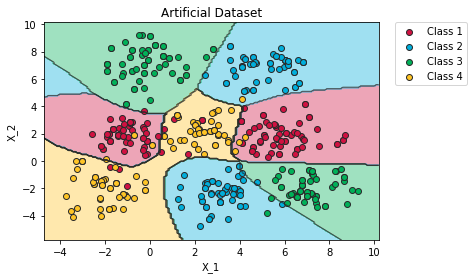

In [14]:
tl.plotClassContour(X_train, y_train, brain)

----